# Classification of imbalanced Datasets
From the Kaggle dataset [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)

## Imports and custom functions

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
pd.set_option('display.max_columns', None)  # Unlimited columns

In [2]:
# Custom function for making train-validate-test splits.
def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
# Colorful confusion matrix generator
def confusion_viz(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return sns.heatmap(matrix, annot=True, 
                       fmt=',', linewidths=1, linecolor='grey', 
                       square=True, 
                       xticklabels=['Predicted\nNO', 'Predicted\nYES'], 
                       yticklabels=['Actual\nNO', 'Actual\nYES'])

## Data inspection
I want to check for nulls, make sure that data types are as expected, and think of whether to drop any columns given the analysis that I intend to make.

In [4]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [5]:
# Yikes, 6 million rows
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Cool, no nulls
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# Data types look good
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

I'm going to assume that fraud isn't really changing over time, and that I lose less from that assumption than I do from not shuffling the data.  As a sanity check, here is a graph of fraud over time.  It seems evenly distributed.

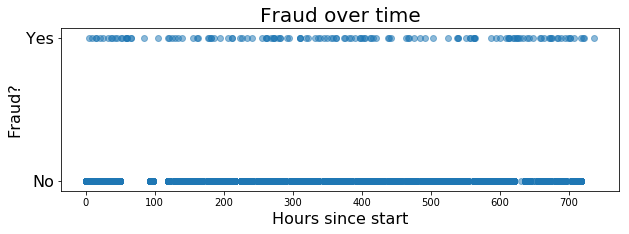

In [20]:
# The full dataset is really large, so I'm going to create a smaller 
# sample of it for quick visualizations like this one.
df_small = df.sample(100000, random_state=42)

fig, ax = plt.subplots(figsize=(10,3))
ax.scatter(df_small.step, df_small.isFraud, alpha=0.5)
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'], fontsize=16)
ax.set_xlabel('Hours since start', fontsize=16)
ax.set_ylabel('Fraud?', fontsize=16)
plt.title('Fraud over time', fontsize=20);

I'll also ignore the variables about who sent and received the money, because those have nearly as many unique values as there are rows in the dataset.  I'm sure that there's some patterns there, but I am also sure that a simple regression won't be able to capture them (and my dataframe will explode if I try to add nine million nearly-empty columns).

In [9]:
df.nameOrig.nunique()

6353307

In [10]:
df.nameDest.nunique()

2722362

## Train-Validate-Test
This dataset is enormous (6 million entries), so there is more than enough data to set some aside for validation and testing. I will now get rid of all the columns mentioned above, and split the dataset for further analysis.

In [11]:
X = df.drop(columns=['isFraud','step','nameOrig','nameDest'])
y = df['isFraud']
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X,y, random_state=42)

## Baseline
First off, what sort of stats do I get if I just assume that there is no fraud ever? (For fraud problems like this one, no fraud is always the majority class)

In [12]:
# 99.8% not fraud
y_train.value_counts(normalize=True)

0    0.998713
1    0.001287
Name: isFraud, dtype: float64

In [13]:
# We can calculate accuracy, though it's not too useful for a dataset
# as imbalanced as this one.
y_pred = np.full(y_val.shape, 0)
accuracy_score(y_val, y_pred)

0.9986687873863282

In [14]:
# A classification report is also not too useful in this case, 
# since several of the metrics come out to zero.
print(classification_report(y_val, y_pred))

/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635415
           1       0.00      0.00      0.00       847

   micro avg       1.00      1.00      1.00    636262
   macro avg       0.50      0.50      0.50    636262
weighted avg       1.00      1.00      1.00    636262



/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


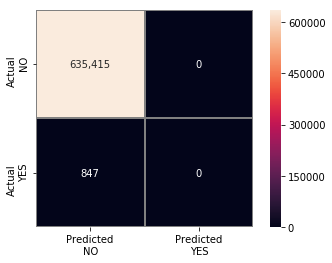

In [15]:
# The confusion matrix reveals why.  With this super-dumb prediction,
# we're just maxing out the false negatives.
confusion_viz(y_val, y_pred);

## Logistic regression
Let's one-hot encode the one categorical variable and run a logistic regression.

In [27]:
pipe = Pipeline([
    ('encoder', ce.OneHotEncoder(use_cat_names=True)),
    ('logreg',LogisticRegression(solver='lbfgs'))
    ])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_val)

In [28]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635415
           1       0.35      0.81      0.49       847

   micro avg       1.00      1.00      1.00    636262
   macro avg       0.67      0.90      0.74    636262
weighted avg       1.00      1.00      1.00    636262



CPU times: user 1.02 s, sys: 44.4 ms, total: 1.06 s
Wall time: 702 ms


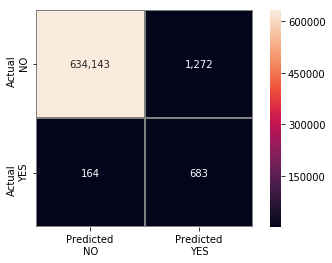

In [54]:
%%time
confusion_viz(y_val, y_pred);

## Tuning the Logistic Regression
Let's see whether we can improve on this by trying out different values of the regularization strength paramter `C` that goes into the Logistic Regression.  This doesn't require anything more complicated than a loop over values of `C`.

In [68]:
%%time
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train2 = encoder.fit_transform(X_train)
X_val2 = encoder.fit_transform(X_val)

In [71]:
%%time
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train2, y_train)

CPU times: user 45.7 s, sys: 4.09 s, total: 49.8 s
Wall time: 27.3 s


In [81]:
%%time
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
y_pred_list=[]
for C in C_values:
    logreg = LogisticRegression(solver='lbfgs', C=C)
    logreg.fit(X_train2, y_train)
    y_pred = logreg.predict(X_val2)
    y_pred_list.append(y_pred)
    print(f'C={C} Done')

C=0.001 Done
C=0.01 Done
C=0.1 Done
C=1 Done
C=10 Done
C=100 Done
CPU times: user 4min 56s, sys: 15.7 s, total: 5min 12s
Wall time: 2min 48s


In [82]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
for y_pred, C in zip(y_pred_list,C_values):
    print(f'C: {C}')
    print(classification_report(y_val, y_pred))
    print('==============================')

C: 0.001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635415
           1       0.35      0.81      0.49       847

   micro avg       1.00      1.00      1.00    636262
   macro avg       0.67      0.90      0.74    636262
weighted avg       1.00      1.00      1.00    636262

C: 0.01
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635415
           1       0.35      0.81      0.49       847

   micro avg       1.00      1.00      1.00    636262
   macro avg       0.67      0.90      0.74    636262
weighted avg       1.00      1.00      1.00    636262

C: 0.1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635415
           1       0.35      0.81      0.49       847

   micro avg       1.00      1.00      1.00    636262
   macro avg       0.67      0.90      0.74    636262
weighted avg       1.00      1.00      1.00    636

Wow, the regression had exactly the same results for all values of C.  I guess this dataset isn't sensitive to this hyperparameter.

## Binning the numerical values
This was suggested as a way of improving classification.  Let's see if it does.

In [165]:
# Columns to discretize
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest']

# One-hot encode works only on the categorical column 'type'
# here we drop all the numerical ones that have to be discretized
# (all but isFlaggedFraud, which stays in X_*2)

onehot = ce.OneHotEncoder(use_cat_names=True)
X_train2 = encoder.fit_transform(X_train).drop(columns=(num_cols)).reset_index(drop=True)
X_val2 = encoder.fit_transform(X_val).drop(columns=num_cols).reset_index(drop=True)

In [182]:
# Discretize the numerical columns
binner = KBinsDiscretizer(encode='ordinal')
X_train3 = binner.fit_transform(X_train[num_cols])
X_val3 = binner.fit_transform(X_val[num_cols])

# Cast as DFs
X_train4 = pd.DataFrame(X_train3, columns=num_cols)
X_val4 = pd.DataFrame(X_val3, columns=num_cols)

# Join again into a single DF ready for regression
X_train5 = X_train2.join(X_train4)
X_val5 = X_val2.join(X_val4)

In [186]:
# Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train5, y_train)
y_pred = logreg.predict(X_val5)

In [187]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635415
           1       1.00      0.02      0.03       847

   micro avg       1.00      1.00      1.00    636262
   macro avg       1.00      0.51      0.52    636262
weighted avg       1.00      1.00      1.00    636262



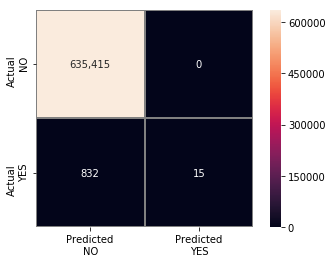

In [188]:
confusion_viz(y_val, y_pred);

Alright, results are in.  The best performance yet is with the original, simple logistic regression. 